In [15]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector, Gate
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import array_to_latex, plot_histogram
from qutip import hilbert_dist, Qobj, fock_dm

import random

import pyswarms as ps
import pyswarms.backend as P
from pyswarms.backend.topology import Star

import numpy as np
import matplotlib.pyplot as plt

First, lets take a look at the Toffoli gate

In [20]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
ccx_gate = Operator(qc).data
array_to_latex(ccx_gate)

<IPython.core.display.Latex object>

We can use the Hilbert Schmitt distance from the qutip library to get the hilbert distance between this and itself. Which of course will be 0

In [21]:
def get_hilbert_shmidt_distance(gate1, gate2):
    return hilbert_dist(Qobj(gate1), Qobj(gate2))

def my_hilbert_schmidt_distance(gate1, gate2):
    return np.sqrt(1 - (np.abs(np.trace(np.conj(gate1).T @ gate2))**2) / (2**3)**2)

In [22]:
print("Hilbert Schmidt Distance of CCX with itself: ", get_hilbert_shmidt_distance(ccx_gate, ccx_gate))
print("My Hilbert Schmidt Distance of CCX with itself: ", my_hilbert_schmidt_distance(ccx_gate, ccx_gate))

Hilbert Schmidt Distance of CCX with itself:  0.0
My Hilbert Schmidt Distance of CCX with itself:  0.0


In [ ]:
class SingleQubitU(Gate):
    def __init__(self, theta, phi, lam):
        super().__init__('U1', 1, [theta, phi, lam])
    
    def _define(self):
        qc = QuantumCircuit(1)
        qc.unitary(self.to_matrix(), [0])
        self.definition = qc
    
    def to_matrix(self):
        theta = float(self.params[0])
        phi = float(self.params[1])
        lam = float(self.params[2])
        return UGate(theta, phi, lam).to_matrix()

In [ ]:
class TwoQubitU(Gate):
    def __init__(self, alpha1, alpha2, alpha3):
        super().__init__('U2', 2, [alpha1, alpha2, alpha3])
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [0, 1])
        self.definition = qc
    def to_matrix(self):
        alpha1 = float(self.params[0])
        alpha2 = float(self.params[1])
        alpha3 = float(self.params[2])

        rxx_gate = RXXGate(alpha1).to_matrix()
        ryy_gate = RYYGate(alpha2).to_matrix()
        rzz_gate = RZZGate(alpha3).to_matrix()

        return rxx_gate @ ryy_gate @ rzz_gate

In [75]:
class ParamVectorItterator:
    def __init__(self, param_vector):
        self.param_vector = param_vector
        self.index = 0
    def __iter__(self):
        return self
    def __next__(self):
        if self.index < len(self.param_vector):
            start = self.index
            end = self.index + 3
            params = self.param_vector[start:end]
            self.index += 3
            return params
        else:
            raise StopIteration

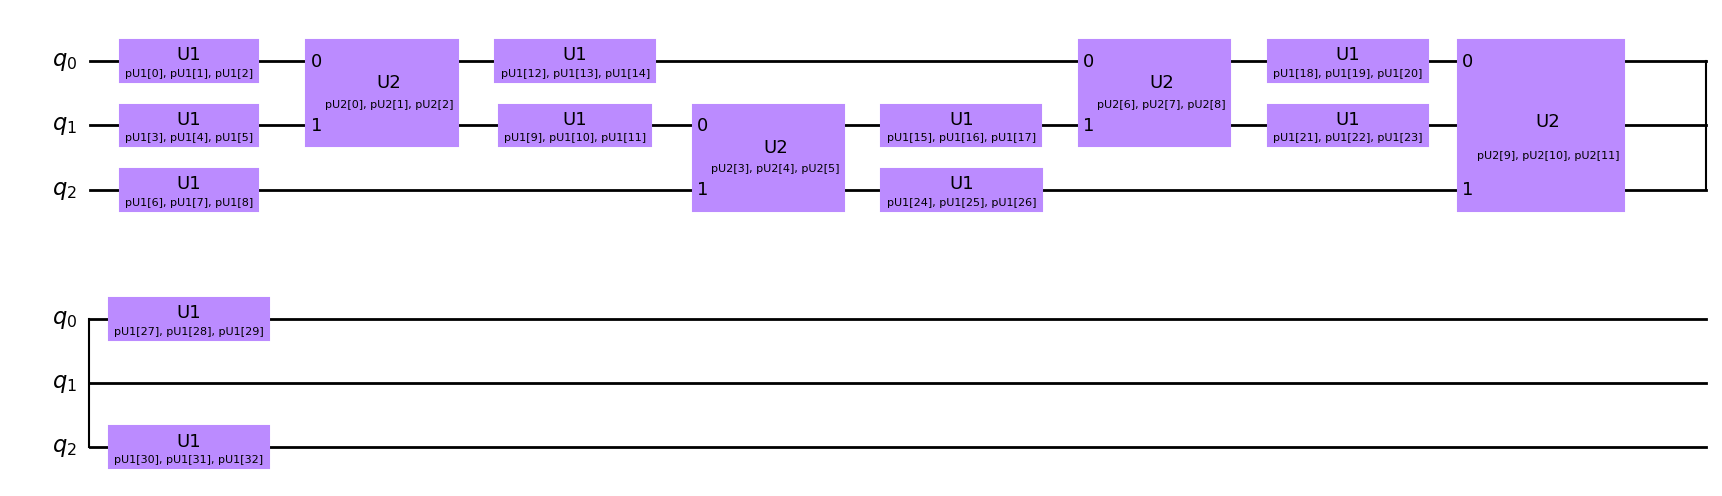

In [76]:
approx_CCNOT_qc = QuantumCircuit(3, name="Approx CCNOT")

# Define parameters
theta = Parameter('theta')
phi = Parameter('phi')
lam = Parameter('lam')

num_U1_params = 3 * 11
num_U2_params = 3 * 4

pU1 = ParameterVector('pU1', num_U1_params)
pU1_itter = ParamVectorItterator(pU1)
pU2 = ParameterVector('pU2', num_U2_params)
pU2_itter = ParamVectorItterator(pU2)

# Create the circuit
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [1, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.draw(output='mpl')

In [69]:
def opt_func(vals):
    distances = []
    for p in vals:
        # Get the circuit
        bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: p[:num_U1_params], pU2: p[num_U1_params:]})

        # Get the matrix
        approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

        # Get the distance
        distances.append(my_hilbert_schmidt_distance(ccx_gate, approx_CCNOT_matrix))

    return distances

Running pyswarms optimization

In [80]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(2*np.pi, num_U1_params + num_U2_params))
init_pos = np.array([best_pos_thus_far for _ in range(250)])
optimizer = ps.single.GlobalBestPSO(n_particles=200, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
cost, pos = optimizer.optimize(opt_func, iters=2500)

print("Total cost: ", cost)
print("Best position: ", pos)

2023-02-23 17:31:48,913 - pyswarms.single.global_best - INFO - Optimize for 2500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|2500/2500, best_cost=0.429
2023-02-23 17:52:48,688 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4287530618177782, best pos: [3.2881299  3.99184176 3.18553378 3.2863268  1.47877481 5.09025655
 2.06475121 2.60927009 3.17647204 2.59969531 3.36538605 3.78667736
 2.66786559 2.8671362  1.69989823 2.57387439 1.70459726 2.55508443
 2.32916717 4.76582611 2.1363075  3.41773472 1.99808937 2.85485426
 3.51766326 2.50742741 3.89748721 2.82860762 4.14244896 3.91760327
 1.92736293 2.2492523  3.38994099 1.57787831 1.57906084 4.01130051
 4.89219643 1.63048575 4.10654436 4.73169744 1.55157382 3.99735117
 4.76154822 1.95726347 4.46895444]


Total cost:  0.4287530618177782
Best position:  [3.2881299  3.99184176 3.18553378 3.2863268  1.47877481 5.09025655
 2.06475121 2.60927009 3.17647204 2.59969531 3.36538605 3.78667736
 2.66786559 2.8671362  1.69989823 2.57387439 1.70459726 2.55508443
 2.32916717 4.76582611 2.1363075  3.41773472 1.99808937 2.85485426
 3.51766326 2.50742741 3.89748721 2.82860762 4.14244896 3.91760327
 1.92736293 2.2492523  3.38994099 1.57787831 1.57906084 4.01130051
 4.89219643 1.63048575 4.10654436 4.73169744 1.55157382 3.99735117
 4.76154822 1.95726347 4.46895444]


In [109]:
# Saving the best position thus far
best_pos_thus_far = pos

Lets observe what the optimized output matrix is

In [104]:
bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: best_pos_thus_far[:num_U1_params], pU2: best_pos_thus_far[num_U1_params:]})
approx_CCNOT_mat = Operator(bound_approx_CCNOT).data
array_to_latex(approx_CCNOT_mat)

<IPython.core.display.Latex object>

This matrix is quite good. However, we could optimize it to get a bit closer.

To start, lets consider the imaginary version of the Hilbert Schmidt Distance; which is of course 2-dimentional

In [110]:
qutip_hs_dist = get_hilbert_shmidt_distance(ccx_gate, Operator(bound_approx_CCNOT).data)
print(qutip_hs_dist)

(25.981858991915477+7.390696236864459j)


Now, lets plot the HS distance on a polar plot centered around zero

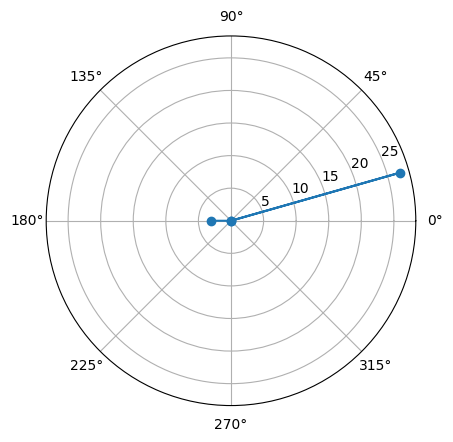

In [108]:
plt.polar([0, np.angle(qutip_hs_dist)], [0, np.abs(qutip_hs_dist)], marker='o')

Lets choose 3 points we can optimize around. Here they are at pi/4, 3pi/4 and 3pi/2

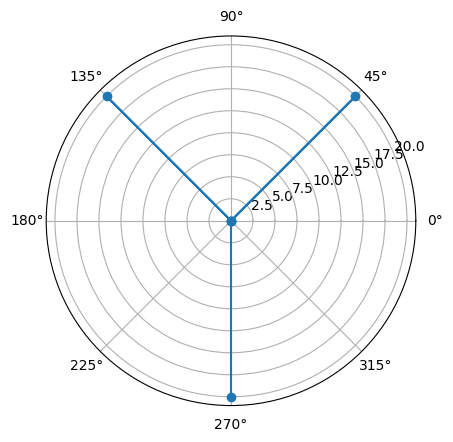

In [115]:
opt_point1 = 20 * np.exp(1j * np.pi/4)
opt_point2 = 20 * np.exp(1j * 3*np.pi/4)
opt_point3 = 20 * np.exp(1j * 3*np.pi/2)

plt.polar([0, np.angle(opt_point1), 0, np.angle(opt_point2),0,np.angle(opt_point3)], [0, np.abs(opt_point1), 0, np.abs(opt_point2),0,np.abs(opt_point3)], marker='o')

If we can possibly optimize a set of matrices centered around *different* points. Then we can use approximate computation (similar to QUEST) by calculating an average matrix of all of them. 

Lets define a new optimization function that takes in a shifted value from the HS distance. Then we perform swam optimization once more on each of these shifted distances

In [125]:
def opt_func_shift(vals, center):
    distances = []
    for p in vals:
        # Get the circuit
        bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: p[:num_U1_params], pU2: p[num_U1_params:]})

        # Get the matrix
        approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

        # Get the distance
        distances.append(get_hilbert_shmidt_distance(ccx_gate, approx_CCNOT_matrix))

    return  distances - center

In [127]:
def swarm(center_point, num_particles=100, num_iters=1000):
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(2*np.pi, num_U1_params + num_U2_params))
    optimizer = ps.single.GlobalBestPSO(n_particles=num_particles, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
    cost, pos = optimizer.optimize(opt_func_shift, iters=num_iters, center=center_point)
    return cost, pos

In [118]:
cost, pos = swarm(opt_point1, num_particles=50, num_iters=500)


2023-02-24 00:16:00,206 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=-2.61+16.3j
2023-02-24 00:32:54,368 - pyswarms.single.global_best - INFO - Optimization finished | best cost: (-2.608894385347419+16.294025426147982j), best pos: [1.38516706 2.51131716 5.27830356 2.74987545 2.50911811 3.52355201
 2.8659545  3.95931036 2.04172439 3.32571896 5.33271026 4.27258749
 3.65899775 4.38659341 2.84488155 2.28802698 2.7637204  3.97048611
 2.14915533 1.75128877 3.05979034 4.41509232 1.95532183 2.96958899
 2.90897814 2.94381205 2.5699538  4.48101636 4.59244171 2.94456253
 0.8090816  4.77583475 2.74841941 3.18127424 3.06147298 2.70042549
 3.04890371 2.91895064 2.72730551 3.42767641 2.1392662  5.26898743
 3.44157068 2.71379828 3.09516083]


Total cost:  (-2.608894385347419+16.294025426147982j)
Best position:  [1.38516706 2.51131716 5.27830356 2.74987545 2.50911811 3.52355201
 2.8659545  3.95931036 2.04172439 3.32571896 5.33271026 4.27258749
 3.65899775 4.38659341 2.84488155 2.28802698 2.7637204  3.97048611
 2.14915533 1.75128877 3.05979034 4.41509232 1.95532183 2.96958899
 2.90897814 2.94381205 2.5699538  4.48101636 4.59244171 2.94456253
 0.8090816  4.77583475 2.74841941 3.18127424 3.06147298 2.70042549
 3.04890371 2.91895064 2.72730551 3.42767641 2.1392662  5.26898743
 3.44157068 2.71379828 3.09516083]


In [120]:
tot_cost = opt_point1+cost
print(tot_cost)

(11.533241238383532+30.436161049878933j)


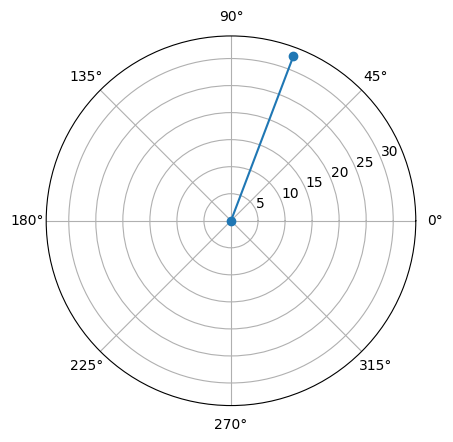

In [121]:
plt.polar([0, np.angle(tot_cost)], [0, np.abs(tot_cost)], marker='o')

In [128]:
swarm(opt_point2, num_particles=100, num_iters=500)

2023-02-24 00:38:18,820 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=15.2-13.1j
2023-02-24 00:46:37,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: (15.219208524540441-13.107129892291955j), best pos: [2.35041951 2.11461755 4.28912991 2.25785433 2.78434017 4.87404442
 2.23891485 0.94588749 4.26584717 1.57430244 3.57886346 2.62797345
 5.54973059 2.86120633 5.02709311 3.07383376 3.57637394 3.00361005
 3.80392149 4.40331012 3.60437739 4.38687429 3.0600922  3.95069232
 2.62534088 2.62385826 3.06509878 3.95090048 3.3335312  2.26001804
 2.84307811 5.11447644 2.61509629 3.30378074 1.46203934 3.57158026
 0.05840743 2.03902423 1.99506391 3.54173363 1.18302256 3.713326
 3.83137102 4.64174806 3.4720999 ]


((15.219208524540441-13.107129892291955j),
 array([2.35041951, 2.11461755, 4.28912991, 2.25785433, 2.78434017,
        4.87404442, 2.23891485, 0.94588749, 4.26584717, 1.57430244,
        3.57886346, 2.62797345, 5.54973059, 2.86120633, 5.02709311,
        3.07383376, 3.57637394, 3.00361005, 3.80392149, 4.40331012,
        3.60437739, 4.38687429, 3.0600922 , 3.95069232, 2.62534088,
        2.62385826, 3.06509878, 3.95090048, 3.3335312 , 2.26001804,
        2.84307811, 5.11447644, 2.61509629, 3.30378074, 1.46203934,
        3.57158026, 0.05840743, 2.03902423, 1.99506391, 3.54173363,
        1.18302256, 3.713326  , 3.83137102, 4.64174806, 3.4720999 ]))

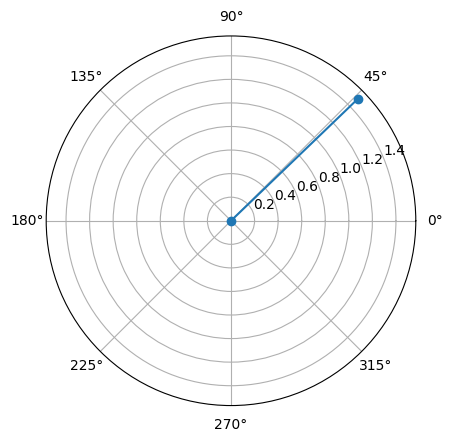

In [132]:
tot_cost = 15.219208524540441-13.107129892291955j + opt_point2
plt.polar([0, np.angle(tot_cost)], [0, np.abs(tot_cost)], marker='o')